## 3-Way ANOVA

The three-way ANOVA is an extension of the two-way ANOVA for assessing whether there is an interaction effect between three independent categorical variables on a continuous outcome variable.

We’ll use the **headache dataset** [datarium package], which contains the measures of migraine headache episode pain score in 72 participants treated with three different treatments. The participants include 36 males and 36 females. Males and females were further subdivided into whether they were at low or high risk of migraine.

We want to understand how each independent variable (type of treatments, risk of migraine and gender) interact to predict the pain score.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

np.random.seed(42)
n = 72
data = {
    'gender': np.repeat(['male', 'female'], n/2),
    'risk': np.tile(np.repeat(['low', 'high'], n/4), 2),
    'treatment': np.tile(np.repeat(['X', 'Y', 'Z'], n/12), 4),
    'pain_score': np.random.normal(loc=50, scale=10, size=n) 
}

df = pd.DataFrame(data)
df.loc[(df['risk'] == 'high') & (df['treatment'] == 'X'), 'pain_score'] += 15
df.loc[df['treatment'] == 'Z', 'pain_score'] -= 10

print(df.head())

  gender risk treatment  pain_score
0   male  low         X   54.967142
1   male  low         X   48.617357
2   male  low         X   56.476885
3   male  low         X   65.230299
4   male  low         X   47.658466



### Descriptive statistics





### Assumptions


#### Outliers




#### Normality




#### Homogeneity of variance




### Anova





### Post-hoc tests

If there is a significant 3-way interaction effect, you can decompose it into:

-    Simple two-way interaction: run two-way interaction at each level of third variable,
-    Simple simple main effect: run one-way model at each level of second variable,
-    Simple simple pairwise comparisons: run pairwise or other post-hoc comparisons if necessary.

If you do not have a statistically significant three-way interaction, you need to determine whether you have any statistically significant two-way interaction from the ANOVA output. You can follow up a significant two-way interaction by simple main effects analyses and pairwise comparisons between groups if necessary.

#### Two-way interactions




#### Main effects



#### Pairwise comparisons

                            mean        std  count
gender risk treatment                             
female high X          68.534431   7.800042      6
            Y          48.668985  10.307525      6
            Z          44.245785   7.712050      6
       low  X          46.712839  10.595412      6
            Y          46.635609   8.317197      6
            Z          37.423890   8.847478      6
male   high X          60.937208  11.011177      6
            Y          46.498186   5.449187      6
            Z          39.635108  11.891989      6
       low  X          53.434797   6.937926      6
            Y          52.484310   8.554530      6
            Z          32.238155   9.508417      6


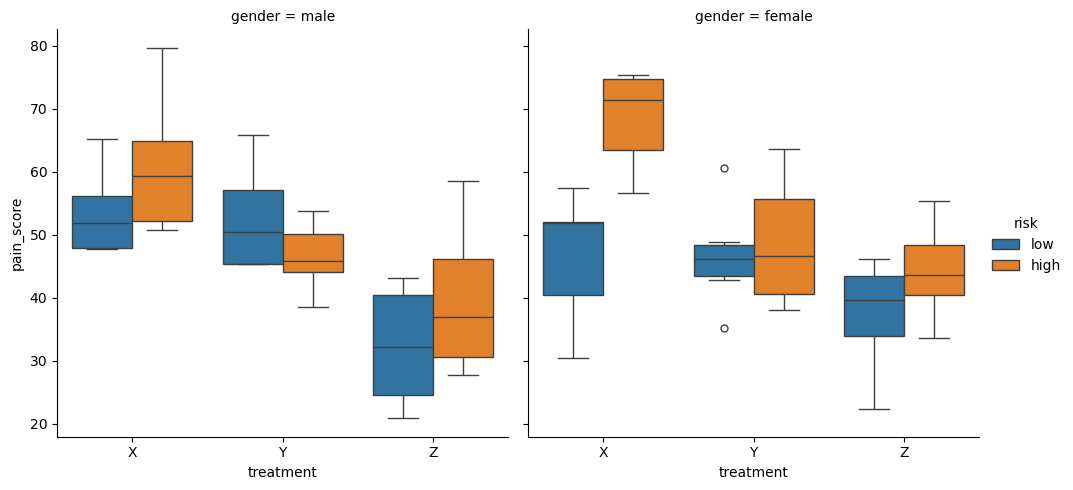

In [2]:
desc_stats = df.groupby(['gender', 'risk', 'treatment'])['pain_score'].agg(['mean', 'std', 'count'])
print(desc_stats)

sns.catplot(x="treatment", y="pain_score", hue="risk", col="gender", kind="box", data=df)
plt.show()

In [3]:
model = ols('pain_score ~ C(gender) * C(risk) * C(treatment)', data=df).fit()
shapiro_test = pg.normality(model.resid)
print(f"Test normalności reszt:\n{shapiro_test}")

levene = pg.homoscedasticity(df, dv='pain_score', group='treatment')
print(f"\nTest jednorodności wariancji (Levene):\n{levene}")

Test normalności reszt:
          W      pval  normal
0  0.979365  0.284096    True

Test jednorodności wariancji (Levene):
               W      pval  equal_var
levene  1.288488  0.282236       True


In [4]:
formula = 'pain_score ~ C(gender) * C(risk) * C(treatment)'
model = ols(formula, data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=3)
print("\n=== WYNIKI 3-WAY ANOVA ===")
print(anova_table)


=== WYNIKI 3-WAY ANOVA ===
                                      sum_sq    df           F        PR(>F)
Intercept                       28181.808985   1.0  341.472922  1.904725e-26
C(gender)                         173.153376   1.0    2.098062  1.526920e-01
C(risk)                          1428.545541   1.0   17.309379  1.027923e-04
C(treatment)                     2008.277801   2.0   12.166935  3.668399e-05
C(gender):C(risk)                 307.558373   1.0    3.726619  5.828180e-02
C(gender):C(treatment)             44.318539   2.0    0.268499  7.654398e-01
C(risk):C(treatment)              639.494252   2.0    3.874307  2.615321e-02
C(gender):C(risk):C(treatment)    167.695355   2.0    1.015964  3.681959e-01
Residual                         4951.808560  60.0         NaN           NaN


In [5]:
print("\n--- Analiza Prostych Interakcji Dwuczynnikowych (Dla płci męskiej) ---")

df_male = df[df['gender'] == 'male']

model_male = ols('pain_score ~ C(risk) * C(treatment)', data=df_male).fit()
anova_male = sm.stats.anova_lm(model_male, typ=3)
print(anova_male)


--- Analiza Prostych Interakcji Dwuczynnikowych (Dla płci męskiej) ---
                            sum_sq    df           F        PR(>F)
Intercept             22280.059803   1.0  265.194680  1.935089e-16
C(risk)                 168.858527   1.0    2.009886  1.665807e-01
C(treatment)           1418.733308   2.0    8.443436  1.233246e-03
C(risk):C(treatment)    361.058411   2.0    2.148800  1.342341e-01
Residual               2520.419319  30.0         NaN           NaN


In [6]:
def run_posthoc(group_df):
    return pg.pairwise_tests(
        data=group_df, 
        dv='pain_score', 
        between='treatment', 
        padjust='bonf'
    )

posthocs = df.groupby('risk').apply(run_posthoc, include_groups=False).reset_index()
posthocs['significant'] = posthocs['p-corr'] < 0.05
cols_to_show = ['risk', 'A', 'B', 'p-unc', 'p-corr', 'significant']

print("--- Wyniki Post-hoc dla interakcji Ryzyko * Leczenie ---")
print(posthocs[cols_to_show])

--- Wyniki Post-hoc dla interakcji Ryzyko * Leczenie ---
   risk  A  B     p-unc    p-corr  significant
0  high  X  Y  0.000116  0.000349         True
1  high  X  Z  0.000011  0.000034         True
2  high  Y  Z  0.136725  0.410176        False
3   low  X  Y  0.889115  1.000000        False
4   low  X  Z  0.000523  0.001568         True
5   low  Y  Z  0.000523  0.001569         True


Conclusion 

A three-way ANOVA was conducted to examine the effects of gender, migraine risk, and treatment type on pain scores.

There was no statistically significant three-way interaction between gender, risk, and treatment (F(2,60)=1.01,p=.368
F(2,60)=1.01,p=.368). However, a significant two-way interaction was found between risk and treatment (F(2,60)=3.87,p=.026).

Subsequent post-hoc analyses (with Bonferroni correction) revealed that the effect of the treatment depends on the risk group. Specifically, Treatment X resulted in significantly higher pain scores than Treatment Y, but this difference was observed only in the High Risk group (p
<.001). In the Low Risk group, no significant differences were found between treatments.